# RL Assignment 05

Roberto Cai Wu / Ramesh Kumar

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Game rules
* The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
* Each draw from the deck results in a value between 1 and 10 (uniformly dis tributed) with a color of red (probability 1/3) or black (probability 2/3).
* There are no aces or picture (face) cards in this game
* At the start of the game both the player and the dealer draw one black card (fully observed)
* Each turn the player may either stick or hit
* If the player hits then he or she draws another card from the deck
* If the player sticks he or she receives no further cards
* The values of the player's cards are added (black cards) or subtracted (red cards)
* If the player's sum exceeds 21, or becomes less than 1, then she \goes bust" and loses the game (reward -1)
* If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise.
* If the dealer goes bust, then the player wins; otherwise, the outcome { win (reward +1), lose (reward -1), or draw (reward 0) } is the player with the largest sum.

In [31]:
class BlackJack(object):
    def __init__(self):
        self.r = [1, 0, -1] # rewards 1 for win, 0 for draw, -1 for loss
        self.a = ['hit', 'stick'] # actions 
        self.color = np.array([[0, 1/3], [1, 2/3]]) # 0: red, 1: black
        self.episodes = 1100
        self.N0 = 50
        self.gamma = 1
        self.d_intervals = [[1,4],[4,7],[7,10]] # cuboid intervals for dealer
        self.p_intervals = [[1,6],[4,9],[7,12],[10,15],[13,18],[16,21]] # cuboid intervals for player
        
    # Draw card from 1 to 10 and the corresponding color
    def draw_card(self):
        card_val = np.random.randint(1,11)
        rand_col = np.random.random()
        if rand_col < self.color[0,1]:
            card_col = 0
        else:
            card_col = 1
        card = [card_val,card_col]
        return card
    
    # check sum of all cards
    def check_sum(self, cards):
        ace = False
        total = 0
        for i in range(len(cards)):
            card = cards[i]
            # red card
            if card[1] == 0:
                total -= card[0]
            # black card
            else:
                total += card[0]
        return total
    
    # player turn to draw card
    def deal_to_player(self):
        cards = []
        cards.append(self.draw_card())
        return self.check_sum(cards)
    
    # Dealer turn to draw card. Dealer will draw cards until it reaches a sum of 17 or greater.
    # It was not explicitly mentioned if dealer goes bust if dealer sum becomes < 1, but we did 
    # include it.
    def play_dealer(self, card, player_sum):
        cards = []
        cards.append(card)
        while self.check_sum(cards) > 0 and self.check_sum(cards) < 18:
            cards.append(self.draw_card())
        return self.check_sum(cards)
    
    # Start game with sum of player's card and dealer card (always starting with black card, 
    # meaning it will always start as a positive number)
    def start_game(self):
        player_sum = np.abs(self.deal_to_player())
        dealer_card = self.draw_card()[0]
        return [dealer_card, player_sum]
    
    # Advance recceives the current state and chosen action to get the next state, reward, and
    # wether the next state is terminal or not
    def advance(self, s, a):
        terminal = False
        if a == 'hit':
            card = self.draw_card()
            if card[0] == 0:
                s[1] += card[0]
            else:
                s[1] -= card[0]   
            # Player goes bust
            if s[1] < 1 or s[1] > 21:
                terminal = True
                r = -1
            # Player still in the game
            else: 
                r = 0
        # action stick
        else:
            terminal = True
            dealer_sum = self.play_dealer([s[0],1],s[1])
            # Dealer goes bust
            if dealer_sum < 0 or dealer_sum > 21:
                r = 1
            # Neither player nor dealer go bust 
            else:
                if dealer_sum > s[1]:
                    r = -1
                elif dealer_sum == s[1]:
                    r = 0
                else:
                    r = 1
        return terminal,s,r
    
    # greedy action
    def get_greedy_action(self, s):
        greedy_a = np.argmax(self.Q[s[0]-1,s[1]-1,:])
        return greedy_a
    
    # Sarsa lambda algorithm
    
    def sarsa_lambda(self):

        l = 0
        l_ind = 0
        rewards = np.zeros(11)
        # Loop continues with lambda between 0 to 1 with increment of 0.1 
        while l <= 1:
            # initialize values for Q, Ns(Number of time states visited), Nsa(total number of states with action)
            self.Q = np.zeros([11,22,2])
            self.Ns = np.zeros([11,22])
            self.Nsa = np.zeros([11,22,2])
            self.e = np.zeros([11,22,2])
            acum_reward = 0
            for i in range(1100):
                s = self.start_game()
                a_ind = np.random.randint(0,2)
                self.Ns[s[0]-1, s[1]-1] += 1
                self.Nsa[s[0]-1, s[1]-1, a_ind] += 1
                not_terminal = True
                while not_terminal:
                    terminal,ns,r = self.advance(s,self.a[a_ind])
                    # accumulate reward after learning for 1000 episodes
                    if i >= 1000:
                        acum_reward += r
            
                    if ns[1] < 1 or ns[1] > 21:
                        break
                    
                    if terminal:
                        not_terminal = False
                    epsilon = self.N0 / (self.N0 + self.Ns[ns[0]-1,ns[1]-1])
                    # explore for first 1000 episodes
                    if i < 1000:
                        rand_a = np.random.random()
                        # explore if less than epsilon
                        if rand_a < epsilon:
                            na_ind = np.random.randint(0,2)
                        # choose greedy action
                        else:
                            na_ind = self.get_greedy_action(ns)
                        # update number of times state visited 
                        self.Ns[ns[0]-1, ns[1]-1] += 1
                        self.Nsa[ns[0]-1, ns[1]-1, na_ind] += 1
                        
                        # compute delta
                        delta = r + self.Q[ns[0]-1, ns[1]-1, na_ind] - self.Q[s[0]-1, s[1]-1, a_ind]

                        self.e[s[0]-1, s[1]-1, a_ind] += 1

                        alpha = 1/self.Nsa[ns[0]-1, ns[1]-1, na_ind] 
                        
                        # Update Q value 
                        self.Q += alpha*delta*self.e
                        self.e = self.gamma*l*self.e

                    else:
                        na_ind = self.get_greedy_action(ns)
                    # update state and action
                    s = ns
                    a_ind = na_ind
                    
            rewards[l_ind] = acum_reward
            # increment lambda by 0.1
            l += 0.1
            l_ind += 1
        l = np.linspace(0, 1, num=11)
#         print(self.e)
        return l,rewards, self.Q     
    
    # compute feature vector
    def feature_vector(self, s, a):
        features = []
        for i in range(len(self.p_intervals)):
            for j in range(len(self.d_intervals)):
                p = self.p_intervals[i]
                d = self.d_intervals[j]
                if p[0] <= s[1] <= p[1] and d[0] <= s[0] <= d[1]:
                    features.append(1)
                else:
                    features.append(0)

        if a == 'hit':
            return np.concatenate([np.array(features), np.zeros(18)])
        else:
            return np.concatenate([np.zeros(18),np.array(features)])
    
    # Linear gradient descent 
    
    def value_function_approximator(self):
        
        l = 0
        l_ind = 0
        rewards = np.zeros(11) # rewards for each lambda
        epsilon = 0.05 # constant exploration 
        alpha = 0.01 # constant step size
        # loop untill lambda equal to 1 with increment of 0.1
        while l <= 1:
            # initialize theta arbitrary
            self.theta = np.random.random(36)*0.5
            acum_reward = 0
            
            for i in range(1100):
                s = self.start_game()
                # choose action between 0 and 1 
                a_ind = np.random.randint(0,2)
                # intialize e 
                self.e = np.zeros(36)
                
                phi = self.feature_vector(s,self.a[a_ind])
                
                not_terminal = True
                while not_terminal:
                    self.e[phi==1] += 1  # accumulate traces
                    
                    terminal,ns,r = self.advance(s,self.a[a_ind])
                    if i >= 1000:
                        acum_reward += r
                        
                    if ns[1] > 21:
                        break
                    
                    if terminal:
                        not_terminal = False
                    
                    if i < 1000:
                        # compute delta
                        delta = r - phi*self.theta.T                 
                        
                        rand_a = np.random.random()
                        # probability less than 1- episoln
                        if rand_a < 1-epsilon:
                            Qa = float(-100000)
                            for act in range(len(self.a)):
                                # compute phi and Q
                                phi_curr = self.feature_vector(ns,self.a[act])
                                Q =  sum(self.theta*phi_curr)
                                if Q > Qa:
                                    Qa = Q
                                    na_ind = act
                                    phi = phi_curr
                        else:
                            na_ind = np.random.randint(0,2)
                            phi = self.feature_vector(ns,na_ind)
                            Qa = sum(self.theta*phi)
                        #  update delta  and theta 
                        delta += self.gamma*Qa
                        self.theta += alpha*delta*self.e
                        self.e = self.gamma*l*self.e

                    else:
                        Qa = float(-100000)
                        for act in range(len(self.a)):
                            phi_curr = self.feature_vector(ns,self.a[act])
                            Q =  sum(self.theta*phi_curr)
                            if Q > Qa:
                                Qa = Q
                                na_ind = act
                                phi = phi_curr
                    s = ns
                    a_ind = na_ind
                    
            rewards[l_ind] = acum_reward
            l += 0.1
            l_ind += 1
        l = np.linspace(0, 1, num=11)
        return l,rewards 

In [32]:
b = BlackJack()

In [33]:
l,r,q = b.sarsa_lambda()
r

array([-26., -16., -26., -22., -26., -38., -46., -20., -28., -18., -26.])

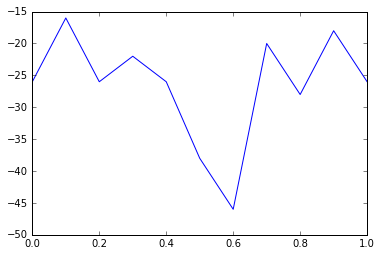

In [34]:
%matplotlib inline
plt.plot(l,r)

In [27]:
# q

In [21]:
l,r = b.value_function_approximator()
r

array([-18., -18., -26., -16.,  -2.,  -8.,   6., -26., -38., -16., -24.])

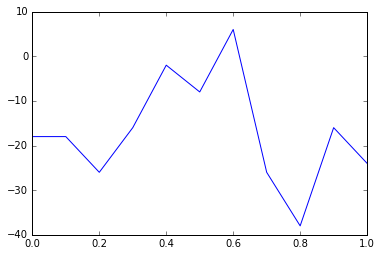

In [22]:
%matplotlib inline
plt.plot(l,r)